In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from heapq import heappop, heappush
from matplotlib.animation import FuncAnimation

def rotate_submatrix(matrix, position, size, angle):
    submatrix = matrix[position[1]:position[1]+size[1], position[0]:position[0]+size[0]]
    rotated_submatrix = rotate(submatrix, angle, reshape=False, order=0)
    return rotated_submatrix

class HybridAStar:
    def __init__(self, start, goal, grid, grid_resolution, yaw_resolution):
        self.start = start
        self.goal = goal
        self.grid = grid
        self.grid_resolution = grid_resolution
        self.yaw_resolution = yaw_resolution
        self.open_set = []
        # (current cost , x, y, direction)
        heappush(self.open_set, (0, start))
        self.came_from = {}
        self.cost_so_far = {}
        self.came_from[start] = None
        self.cost_so_far[start] = 0

    def heuristic(self, a, b):
        return np.linalg.norm(np.array(a[:2]) - np.array(b[:2]))

    def search(self):
        while self.open_set:
            current_cost, current = heappop(self.open_set)
            if self.is_goal(current):
                return self.reconstruct_path(current)

            for next in self.get_neighbors(current):
                new_cost = self.cost_so_far[current] + self.cost(current, next)
                if next not in self.cost_so_far or new_cost < self.cost_so_far[next]:
                    self.cost_so_far[next] = new_cost
                    priority = new_cost + self.heuristic(next, self.goal)
                    heappush(self.open_set, (priority, next))
                    self.came_from[next] = current
        return []

    def get_neighbors(self, current):
        neighbors = []
        for d in [-1, 0, 1]:  # three possible steering angles
            for step in range(1, 10):  # step size
                new_yaw = current[2] + d * self.yaw_resolution
                new_x = current[0] + step * self.grid_resolution * np.cos(new_yaw)
                new_y = current[1] + step * self.grid_resolution * np.sin(new_yaw)
                new_pos = (int(new_x), int(new_y), new_yaw)
                if self.is_valid(new_pos):
                    neighbors.append(new_pos)
        return neighbors

    def is_valid(self, pos):
        x, y = int(pos[0]), int(pos[1])
        if 0 <= x < self.grid.shape[1] and 0 <= y < self.grid.shape[0]:
            return self.grid[y, x] == 0
        return False

    def cost(self, current, next):
        return np.linalg.norm(np.array(current[:2]) - np.array(next[:2]))

    def is_goal(self, pos):
        return np.linalg.norm(np.array(pos[:2]) - np.array(self.goal[:2])) < self.grid_resolution

    def reconstruct_path(self, current):
        path = []
        while current is not None:
            path.append(current)
            current = self.came_from[current]
        path.reverse()
        return path

###### 이미지 전체 크기 ######
#차선 폭 : 15cm, 차로 폭 : 3m, 여백 : 15cm
margin, line_width = 15, 15
lane_width, car_width = int(line_width * 20), int(line_width * 12.7)
car_height = int(car_width*2.63)
width, height = 5*line_width+2*lane_width, 2000
grid = np.zeros((height, width))

###### 차선 ######
left_line, center_line, right_line = int(margin), int(2*margin + lane_width), int(width - margin - line_width)

# 차선을 그리기
grid[:, left_line:left_line + line_width] = 1
grid[:, right_line:right_line + line_width] = 1
        
# ###### 주변 차량 ######
# # 좌하측 위치, 너비, 높이
# other_car = [(85, 50), (85, 700), (85,1300)]
# cnt = 2
# for cx, cy in other_car:
#     grid[cy:cy+car_height+1, cx:cx+car_width+1] = cnt
#     cnt += 1




In [2]:
# 시작 및 목표 지점 설정
start = (85, 50, 0)
goal = (500, 500, 0)
grid_resolution = 5.0
yaw_resolution = np.deg2rad(15.0)
planner = HybridAStar(start, goal, grid, grid_resolution, yaw_resolution)
path = planner.search()

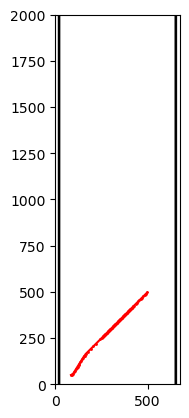

In [5]:
# 경로 시각화
def visualize_path(grid, path):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='Greys', origin='lower')

    x = [p[0] for p in path]
    y = [p[1] for p in path]

    ax.plot(x, y, marker='o', color='r', markersize = 1)

    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

visualize_path(grid, path)